In [1]:
# pip install git+https://github.com/IBM/tsfm.git
# pip install transformers
# pip install bottleneck --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from transformers import EarlyStoppingCallback, PatchTSTConfig, PatchTSTForPrediction, Trainer, TrainingArguments
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index


In [3]:
dataset_path = r"Data\participant_training_jobs_full_data.csv"
timestamp_column = "timestamp"
id_columns = ['job_id', 'host']
forecast_columns = ['block','cpuuser','gpu_usage','memused','memused_minus_diskcache','nfs']
context_length = 12
forecast_horizon = 1
patch_length = 4
num_workers = 12
batch_size = 64

In [4]:
data = pd.read_csv(dataset_path, parse_dates=[timestamp_column])
data.drop(['ts_delta'], axis=1, inplace=True)
# data.drop(['ts_delta','job_id', 'host'], axis=1, inplace=True)

# num_train = int(len(data) * 0.7)
# num_test = int(len(data) * 0.2)
# num_valid = len(data) - num_train - num_test
# border1s = [
#     0,
#     num_train - context_length,
#     len(data) - num_test - context_length,
# ]
# border2s = [num_train, num_train + num_valid, len(data)]

# train_start_index = border1s[0]  # None indicates beginning of dataset
# train_end_index = border2s[0]

# # we shift the start of the evaluation period back by context length so that
# # the first evaluation timestamp is immediately following the training data
# valid_start_index = border1s[1]
# valid_end_index = border2s[1]

# test_start_index = border1s[2]
# test_end_index = border2s[2]

# train_data = select_by_index(
#     data,
#     id_columns=id_columns,
#     start_index=train_start_index,
#     end_index=train_end_index,
# )
# valid_data = select_by_index(
#     data,
#     id_columns=id_columns,
#     start_index=valid_start_index,
#     end_index=valid_end_index,
# )

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=0,
    end_index=60,
)
val_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=60-context_length,
    end_index=None,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    scaling=True,
)

time_series_preprocessor = time_series_preprocessor.train(train_data)

train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
val_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(val_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

config = PatchTSTConfig(
    num_input_channels=len(forecast_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.2,
    d_model=90, # 128
    num_attention_heads=3, # 16
    num_hidden_layers=2,
    ffn_dim=256,
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm",
)
model = PatchTSTForPrediction(config)

training_args = TrainingArguments(
    output_dir=r"Data\results",
    overwrite_output_dir=True,
    num_train_epochs=10,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir=r"Data\logs",
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

In [6]:
trainer.train()

  0%|          | 0/10280 [00:00<?, ?it/s]

{'loss': 0.8377, 'grad_norm': 1.7720588445663452, 'learning_rate': 4.5e-05, 'epoch': 1.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 725.2202758789062, 'eval_runtime': 89.1653, 'eval_samples_per_second': 141.782, 'eval_steps_per_second': 2.221, 'epoch': 1.0}
{'loss': 0.8246, 'grad_norm': 1.3442178964614868, 'learning_rate': 4e-05, 'epoch': 2.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 723.2803344726562, 'eval_runtime': 89.0487, 'eval_samples_per_second': 141.967, 'eval_steps_per_second': 2.224, 'epoch': 2.0}
{'loss': 0.8222, 'grad_norm': 1.7874211072921753, 'learning_rate': 3.5e-05, 'epoch': 3.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 719.6032104492188, 'eval_runtime': 78.7627, 'eval_samples_per_second': 160.507, 'eval_steps_per_second': 2.514, 'epoch': 3.0}
{'loss': 0.82, 'grad_norm': 1.2664830684661865, 'learning_rate': 3e-05, 'epoch': 4.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 719.0403442382812, 'eval_runtime': 84.2226, 'eval_samples_per_second': 150.102, 'eval_steps_per_second': 2.351, 'epoch': 4.0}
{'loss': 0.8186, 'grad_norm': 0.9834144115447998, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 721.58154296875, 'eval_runtime': 85.4887, 'eval_samples_per_second': 147.879, 'eval_steps_per_second': 2.316, 'epoch': 5.0}
{'loss': 0.8176, 'grad_norm': 1.5519720315933228, 'learning_rate': 2e-05, 'epoch': 6.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 715.9336547851562, 'eval_runtime': 86.1718, 'eval_samples_per_second': 146.707, 'eval_steps_per_second': 2.298, 'epoch': 6.0}
{'loss': 0.8168, 'grad_norm': 1.7306690216064453, 'learning_rate': 1.5e-05, 'epoch': 7.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 719.5103759765625, 'eval_runtime': 81.0838, 'eval_samples_per_second': 155.913, 'eval_steps_per_second': 2.442, 'epoch': 7.0}
{'loss': 0.8163, 'grad_norm': 2.2544095516204834, 'learning_rate': 1e-05, 'epoch': 8.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 717.0769653320312, 'eval_runtime': 78.3385, 'eval_samples_per_second': 161.377, 'eval_steps_per_second': 2.527, 'epoch': 8.0}
{'loss': 0.8151, 'grad_norm': 1.5485260486602783, 'learning_rate': 5e-06, 'epoch': 9.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 718.5050048828125, 'eval_runtime': 89.1961, 'eval_samples_per_second': 141.733, 'eval_steps_per_second': 2.22, 'epoch': 9.0}
{'loss': 0.8148, 'grad_norm': 1.8734850883483887, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 717.2861938476562, 'eval_runtime': 81.8855, 'eval_samples_per_second': 154.386, 'eval_steps_per_second': 2.418, 'epoch': 10.0}
{'train_runtime': 1437.2229, 'train_samples_per_second': 457.549, 'train_steps_per_second': 7.153, 'train_loss': 0.8203684231650504, 'epoch': 10.0}


TrainOutput(global_step=10280, training_loss=0.8203684231650504, metrics={'train_runtime': 1437.2229, 'train_samples_per_second': 457.549, 'train_steps_per_second': 7.153, 'total_flos': 45476890905600.0, 'train_loss': 0.8203684231650504, 'epoch': 10.0})

In [7]:
predictions = trainer.predict(test_dataset=val_dataset)

  0%|          | 0/198 [00:00<?, ?it/s]

In [8]:
def trainer_prediction_output_to_df(output, idx:int, count:int=12642):
    return pd.DataFrame({
        'block':list(output[0][idx].reshape((count,6))[:, 0])+list(output[1].reshape((count,6))[:, 0]),
        'cpuuser':list(output[0][idx].reshape((count,6))[:, 1])+list(output[1].reshape((count,6))[:, 1]),
        'gpu_usage':list(output[0][idx].reshape((count,6))[:, 2])+list(output[1].reshape((count,6))[:, 2]),
        'memused':list(output[0][idx].reshape((count,6))[:, 3])+list(output[1].reshape((count,6))[:, 3]),
        'memused_minus_diskcache':list(output[0][1].reshape((count,6))[:, 4])+list(output[1].reshape((count,6))[:, 4]),
        'nfs':list(output[0][idx].reshape((count,6))[:, 5])+list(output[1].reshape((count,6))[:, 5]),
        'type':['prediction']*count + ['truth']*count
        })
    

In [9]:
def trainer_prediction_output_to_df_v2(output):
    return pd.DataFrame({
        'block_prediction':output[0][1].reshape((12642,6))[:, 0],
        'block_truth':output[1].reshape((12642,6))[:, 0],
        'cpuuser_prediction':output[0][1].reshape((12642,6))[:, 1],
        'cpuuser_truth':output[1].reshape((12642,6))[:, 1],
        'gpu_usage_prediction':output[0][1].reshape((12642,6))[:, 2],
        'gpu_usage_truth':output[1].reshape((12642,6))[:, 2],
        'memused_prediction':output[0][1].reshape((12642,6))[:, 3],
        'memused_truth':output[1].reshape((12642,6))[:, 3],
        'memused_minus_diskcache_prediction':output[0][1].reshape((12642,6))[:, 4],
        'memused_minus_diskcache_truth':output[1].reshape((12642,6))[:, 4],
        'nfs_prediction':output[0][1].reshape((12642,6))[:, 5],
        'nfs_truth':output[1].reshape((12642,6))[:, 5]
    })

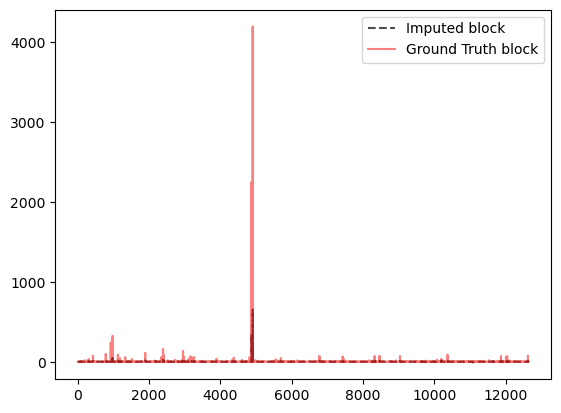

RMSE: 43.83890937952195


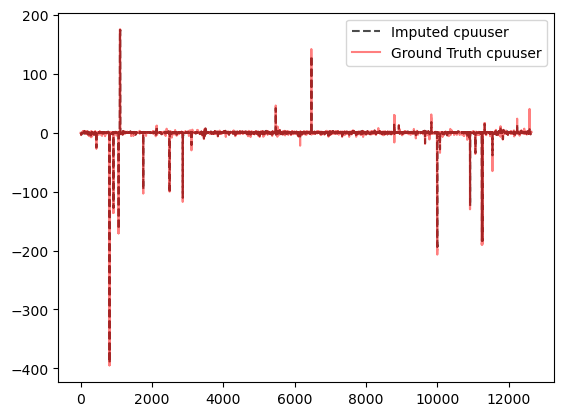

RMSE: 6.9978536312455075


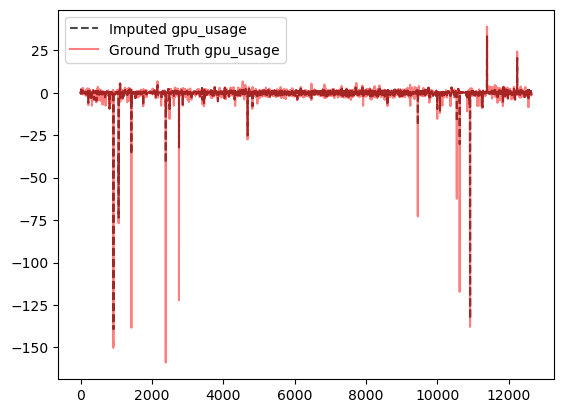

RMSE: 4.004451896890115


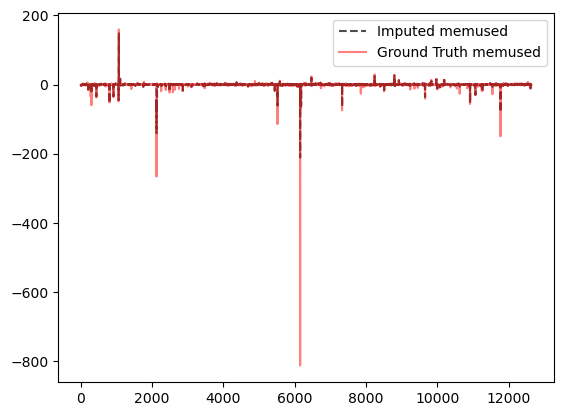

RMSE: 10.127461452104727


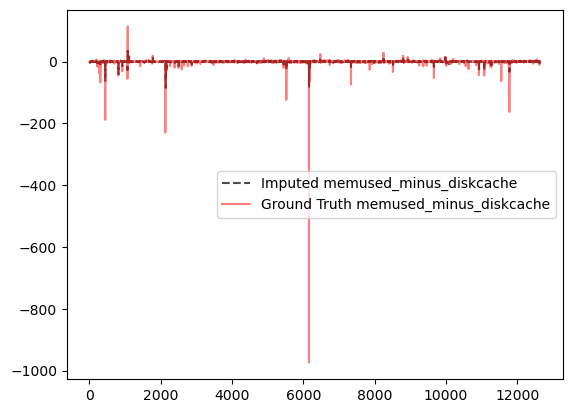

RMSE: 13.40241946113124


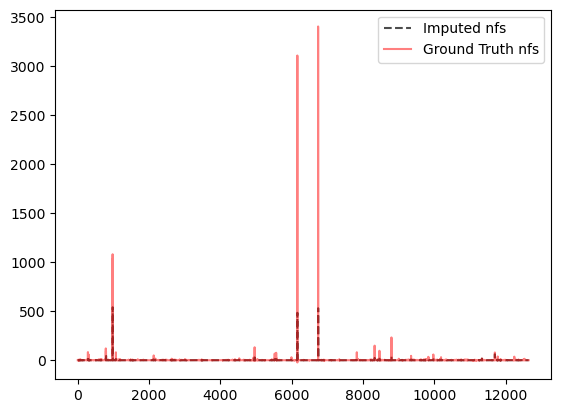

RMSE: 45.46193301560796


In [10]:
val_out = trainer_prediction_output_to_df(predictions, 0)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")

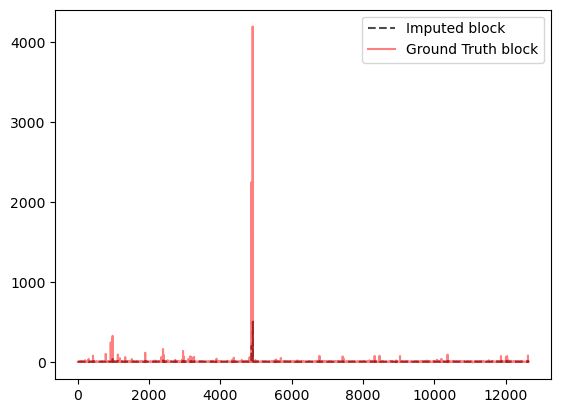

RMSE: 44.54727370700212


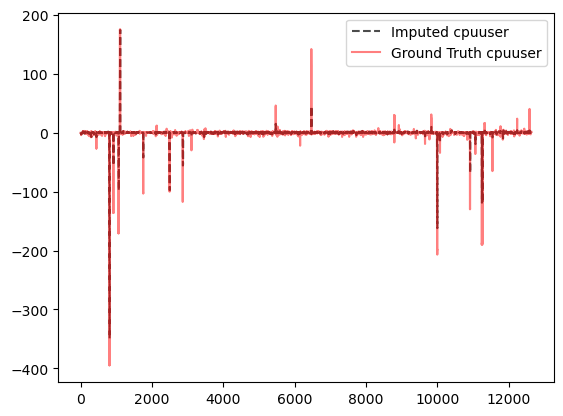

RMSE: 11.917712043490667


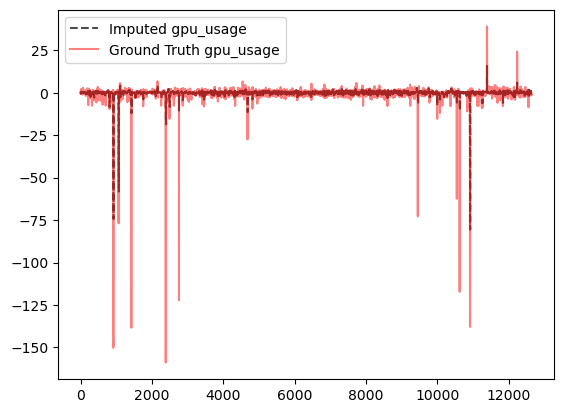

RMSE: 5.015560161611185


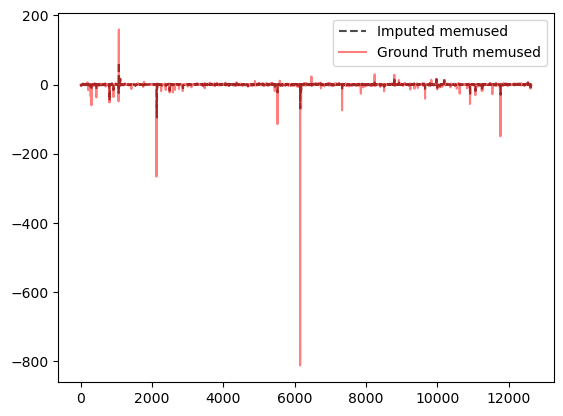

RMSE: 11.56150689886318


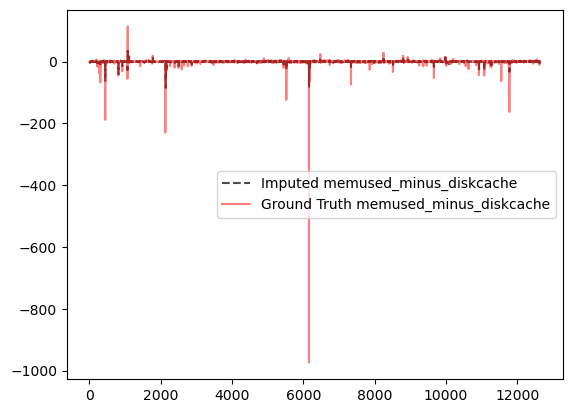

RMSE: 13.40241946113124


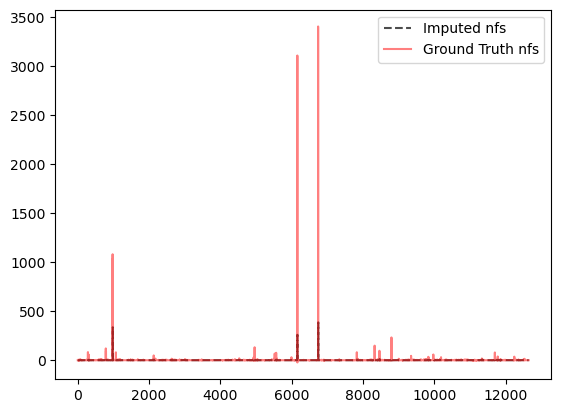

RMSE: 45.255511037849026


In [11]:
val_out = trainer_prediction_output_to_df(predictions, 1)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")

In [12]:
# alt

id_columns = []

data = pd.read_csv(dataset_path, parse_dates=[timestamp_column])
data.drop(['ts_delta','job_id', 'host'], axis=1, inplace=True)

num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_valid = len(data) - num_train - num_test
border1s = [
    0,
    num_train - context_length,
    len(data) - num_test - context_length,
]
border2s = [num_train, num_train + num_valid, len(data)]

train_start_index = border1s[0]
train_end_index = border2s[0]

valid_start_index = border1s[1]
valid_end_index = border2s[1]


train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
val_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    scaling=True,
)

time_series_preprocessor = time_series_preprocessor.train(train_data)

train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
val_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(val_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

config = PatchTSTConfig(
    num_input_channels=len(forecast_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.2,
    d_model=90, # 128
    num_attention_heads=3, # 16
    num_hidden_layers=2,
    ffn_dim=256,
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm",
)
model = PatchTSTForPrediction(config)

training_args = TrainingArguments(
    output_dir=r"Data\results_alt",
    overwrite_output_dir=True,
    num_train_epochs=2,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir=r"Data\logs_alt",
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

c:\Users\danie\anaconda3\envs\new_env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
trainer.train()

  0%|          | 0/2076 [00:00<?, ?it/s]

{'loss': 0.6279, 'grad_norm': 4.914384365081787, 'learning_rate': 2.5e-05, 'epoch': 1.0}


  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.1677304357290268, 'eval_runtime': 71.2286, 'eval_samples_per_second': 133.163, 'eval_steps_per_second': 2.092, 'epoch': 1.0}
{'loss': 0.5977, 'grad_norm': 2.7795047760009766, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.1653745174407959, 'eval_runtime': 68.6364, 'eval_samples_per_second': 138.192, 'eval_steps_per_second': 2.171, 'epoch': 2.0}
{'train_runtime': 245.2249, 'train_samples_per_second': 541.356, 'train_steps_per_second': 8.466, 'train_loss': 0.6127854716571081, 'epoch': 2.0}


TrainOutput(global_step=2076, training_loss=0.6127854716571081, metrics={'train_runtime': 245.2249, 'train_samples_per_second': 541.356, 'train_steps_per_second': 8.466, 'total_flos': 9180716507424.0, 'train_loss': 0.6127854716571081, 'epoch': 2.0})

In [22]:
predictions = trainer.predict(test_dataset=val_dataset)

In [ ]:
val_out = trainer_prediction_output_to_df(predictions, 0)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")

In [ ]:
val_out = trainer_prediction_output_to_df(predictions, 1)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")